In [1]:
# Generales
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pydot as pyd
import time
import joblib

# image preprocessing
import os
import sys
import shutil
import glob
import matplotlib.image as mpimg
from PIL import Image

#sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

#keras
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout, BatchNormalization
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils.vis_utils import plot_model

# tensorflow
import tensorflow as tf
from tensorflow.random import set_seed

#cv2
import cv2
from google.colab.patches import cv2_imshow

In [5]:
set_seed(42)
np.random.seed(42)

In [7]:
# Constants

# dirs
inp_img_dir = "./samples/"
out_dir = ""

# init
start_num = 1

height, width = 32, 32

# placeholder
r = "rule_"

# Classes
class1 = [0, 8, 32, 40, 128, 136, 160, 168]
class2 = [
          1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 19,
          23, 24, 25, 26, 27, 28, 29, 33, 34, 35, 36, 37, 38,
          42, 43, 44, 46, 50, 51, 56, 57, 58, 62, 72, 73, 74,
          76, 77, 78, 94, 104, 108, 130, 132, 134, 138, 140,
          142, 152, 154, 156, 162, 164, 170, 172, 178, 184,
          200, 204, 232
        ]
class3 = [18, 22, 30, 45, 60, 90, 105, 122, 126, 146, 150]
class4 = [41, 54, 106, 110]

## Dataset Organization



In [8]:
def getPics(classRules, samplesDir):
    classImgs = []

    for r in classRules:
        imgsDir = samplesDir + f'rule_{str(r)}/'
        classImgs += [imgsDir + f for f in os.listdir(imgsDir)]
    return classImgs


c1_img_list = getPics(class1 + class2 + class3, inp_img_dir)
c4_img_list = getPics(class4, inp_img_dir)

## Data Prep

In [9]:
len(c1_img_list), len(c4_img_list)

(21504, 21486)

In [10]:
files_target = [np.full(len(c1_img_list), '1', dtype=str),
                np.full(len(c4_img_list), '4', dtype=str) ]
[x.shape[0] for x in files_target]

[21504, 21486]

In [11]:
# Data selection
endl = len(c4_img_list)
c1_x = c1_img_list[:endl].copy()
c4_x = c4_img_list[:endl].copy()

c1_y = files_target[0][:endl].copy()
c4_y = files_target[1][:endl].copy()

In [12]:
len(c1_x), len(c4_x)

(21486, 21486)

In [13]:
c_x = np.array(c1_x+c4_x)
c_y = np.concatenate((c1_y, c4_y))

In [14]:
dataset = pd.DataFrame({'img':c_x, 'class':c_y})
dataset = dataset.sample(frac=1)
dataset

,img,class
28319,./samples/rule_54/54_000_0204_6095.png,4
21987,./samples/rule_41/41_000_0060_8030.png,4
12702,./samples/rule_76/76_000_0191_1702.png,1
26595,./samples/rule_41/41_000_0159_6112.png,4
10388,./samples/rule_50/50_000_0040_9892.png,1
...,...,...
6265,./samples/rule_24/24_000_0230_8183.png,1
11284,./samples/rule_58/58_000_0138_6445.png,1
38158,./samples/rule_110/110_000_0248_4006.png,4
860,./samples/rule_40/40_000_0254_4772.png,1


## Data Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(dataset['img'].values, dataset['class'].values, test_size=0.33, random_state=42)

# Reshape

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# one hot encoding
enc = OneHotEncoder(sparse=False)
enc.fit(y_train)

# save encode
joblib.dump(enc, '../encodings/encoder' + '_comelli_V2_4vr' + '.joblib')

# transform data
y_train = enc.transform(y_train)

print(pd.DataFrame(y_train, columns=list(enc.categories_[0])).head())

# tranform encoding for test data
y_test = enc.transform(y_test)
# to print the encoded features for train data
print(pd.DataFrame(y_test, columns=list(enc.categories_[0])).head())

     1    4
0  0.0  1.0
1  1.0  0.0
2  0.0  1.0
3  1.0  0.0
4  1.0  0.0
     1    4
0  1.0  0.0
1  0.0  1.0
2  0.0  1.0
3  1.0  0.0
4  1.0  0.0


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [16]:
X_train[325], y_train[325]

('./samples/rule_6/6_000_0231_6702.png', array([1., 0.]))

## Images

In [17]:
def getImages(files):
    img_list = []

    for img in files:
        img1 = load_img(out_dir + img, color_mode='grayscale')
        x = img_to_array(img1) / 255

        img_list.append(x)

    return np.array(img_list)

In [18]:
# Images Preview
def imagePreview(imgsArr):
    imgs_show = [imgsArr[0], imgsArr[50], imgsArr[2589], imgsArr[-4]]
    plt.figure(figsize=(16,8))
    columns = 4

    for i, image in enumerate(imgs_show):
        plt.subplot(len(imgs_show) // columns + 1, columns, i + 1)

        plt.imshow(array_to_img(image))

    plt.figure()
    plt.show()

In [19]:
X_train = getImages(X_train)

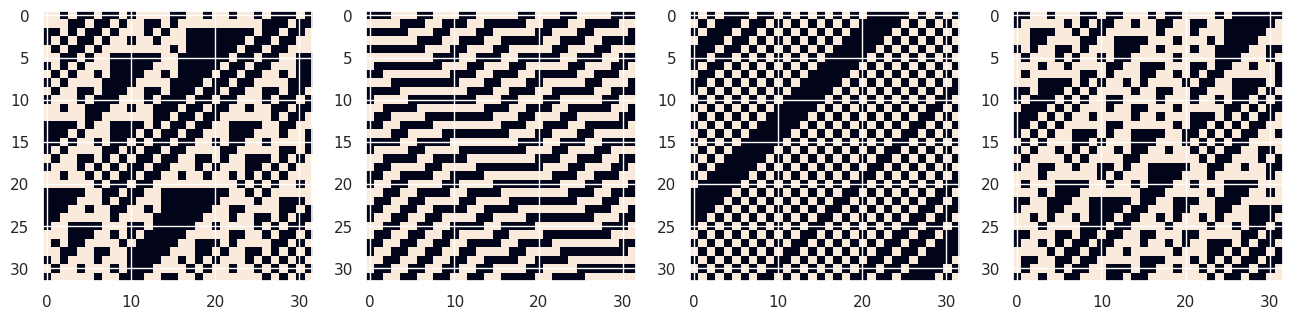

<Figure size 640x480 with 0 Axes>

In [20]:
imagePreview(X_train)

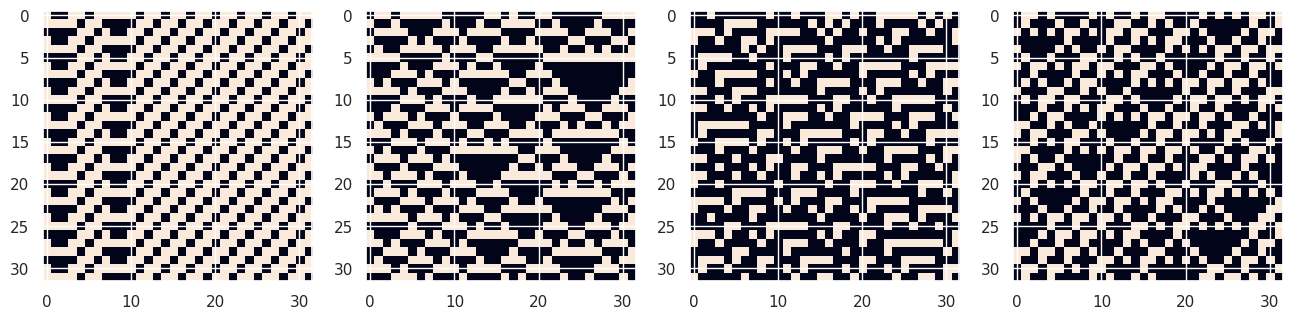

<Figure size 640x480 with 0 Axes>

In [21]:
X_test = getImages(X_test)

imagePreview(X_test)

In [22]:
X_train[0].shape

(32, 32, 1)

## Training

In [27]:
# parameters
kernel = 3
stride = 2

# input
inputs_conv1 = keras.Input(shape=(height, width, 1), name='conv1')

# CNN
conv1 = Conv2D(32, kernel, activation='relu', name='conv2')(inputs_conv1)
pool1 = MaxPooling2D(stride, name='pool1')(conv1)
conv1 = Conv2D(32, kernel, activation='relu',name='conv3')(pool1)

flat = Flatten(name='flt')(conv1)

dense = Dense(64, activation='relu', name='dense')(flat)

# out
output = Dense(2, activation='softmax', name='out')(dense)


model = Model(inputs=inputs_conv1, outputs=output)

model.build((None,height,width,1))

In [28]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (InputLayer)          [(None, 32, 32, 1)]       0         
                                                                 
 conv2 (Conv2D)              (None, 30, 30, 32)        320       
                                                                 
 pool1 (MaxPooling2D)        (None, 15, 15, 32)        0         
                                                                 
 conv3 (Conv2D)              (None, 13, 13, 32)        9248      
                                                                 
 flt (Flatten)               (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 64)                346176    
                                                                 
 out (Dense)                 (None, 2)                 130 

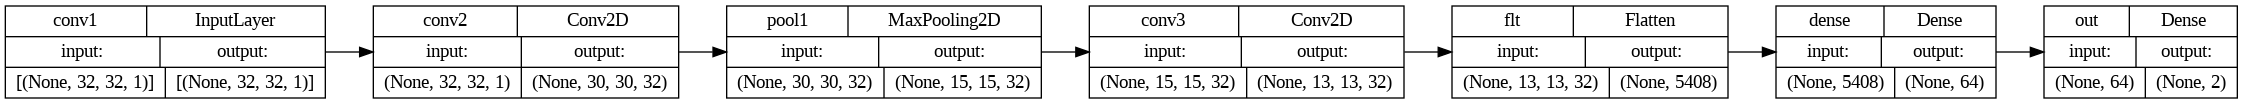

In [29]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='LR')

In [30]:
# Model
save_dir = '../best_models/comelli_V2_4vr_best.h5'

# 1e-2
opt = Adam(learning_rate=1e-2, amsgrad=True)
met = tf.keras.metrics.CategoricalAccuracy()

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=[met])

checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir,
                                                monitor='val_categorical_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='max')

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max',
                                      min_delta=0.05, verbose=1, patience=15)

callbacks_list = [checkpoint, es]

hist = model.fit(x = X_train,
                 y = y_train,
                 validation_data=([X_test], y_test),
                 # ep 50, b 12
                 epochs=200,
                 batch_size=64,
                 verbose=1,
                 callbacks=callbacks_list )

Epoch 1/200
450/450 [==============================] - ETA: 0s - loss: 0.2195 - categorical_accuracy: 0.9141
Epoch 1: val_categorical_accuracy improved from -inf to 0.99492, saving model to ./drive/Shareddrives/Memoria/code/best_models/comelli_V2_4vr_best.h5
450/450 [==============================] - 15s 8ms/step - loss: 0.2195 - categorical_accuracy: 0.9141 - val_loss: 0.0202 - val_categorical_accuracy: 0.9949
Epoch 2/200
442/450 [============================>.] - ETA: 0s - loss: 0.0306 - categorical_accuracy: 0.9905
Epoch 2: val_categorical_accuracy improved from 0.99492 to 0.99598, saving model to ./drive/Shareddrives/Memoria/code/best_models/comelli_V2_4vr_best.h5
450/450 [==============================] - 3s 7ms/step - loss: 0.0302 - categorical_accuracy: 0.9907 - val_loss: 0.0137 - val_categorical_accuracy: 0.9960
Epoch 3/200
443/450 [============================>.] - ETA: 0s - loss: 0.0035 - categorical_accuracy: 0.9988
Epoch 3: val_categorical_accuracy improved from 0.99598 to 

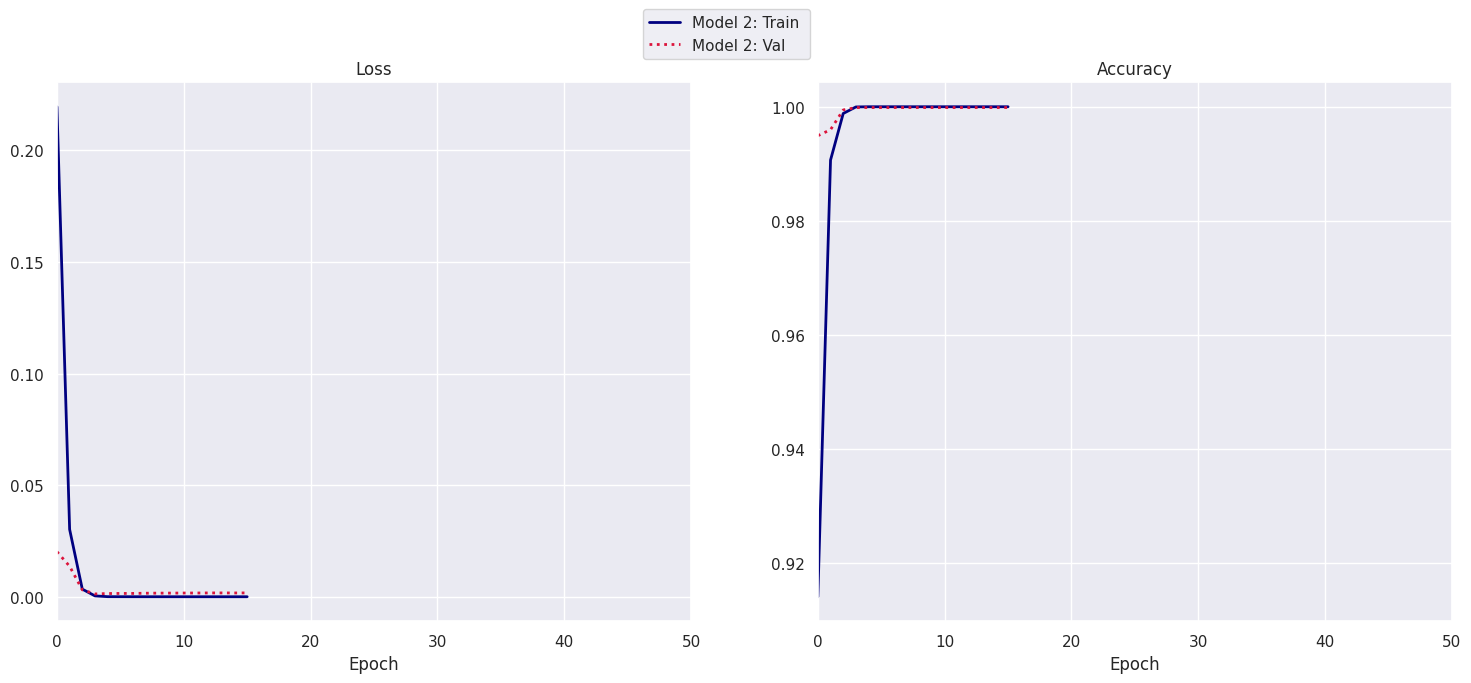

In [31]:
fig = plt.figure(figsize=(18, 7), facecolor='w', edgecolor='k')
gs  = gridspec.GridSpec(nrows=1, ncols=2)
ax = plt.subplot(gs[0, 0]), plt.subplot(gs[0, 1])

colors_list = ["crimson", "orchid", "navy", "aqua"]

num=2
l1 = ax[0].plot(hist.history['loss'], c=colors_list[num] ,label='Model '+str(num)+': Train ', linewidth=2)
ax[0].plot(hist.history['val_loss'], ls='dotted', c=colors_list[0], label='Model '+str(num)+': Val', linewidth=2)

ax[1].plot(hist.history['categorical_accuracy'], c=l1[0].get_color(), linewidth=2)
ax[1].plot(hist.history['val_categorical_accuracy'], ls='dotted', c=colors_list[0], linewidth=2)

# labels
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_xlim([0, 50])
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_xlim([0, 50])

handles, labels = ax[0].get_legend_handles_labels()
plt.legend(labels, loc="best", bbox_to_anchor=(0, 1.15))
plt.show()